# NeuTra
Based on NeuTra-lizing Bad Geometry in Hamiltonian Monte Carlo Using Neural Transport" by Hoffman et al. (Symposium on Approximate Bayesian Inference 2018)

In [5]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental import stax
import numpyro.distributions as dist
from numpyro.distributions import constraints
import numpyro
from jax.scipy.special import logsumexp
from numpyro.infer.stein import SVGD
from numpyro.infer.kernels import RBFKernel
from numpyro.contrib.autoguide import AutoDelta
from numpyro.infer.initialization import init_with_noise, init_to_value
from numpyro.nn.auto_reg_nn import AutoregressiveNN
from numpyro.distributions.flows import InverseAutoregressiveTransform
from numpyro.distributions.transforms import (
    ComposeTransform,
    PermuteTransform
)
from numpyro.infer.guide import WrappedGuide
from numpyro.optim import Adam
from numpyro.infer import ELBO
import seaborn as sns
import matplotlib.pyplot as plt

## Double Moon Distribution

In [6]:
class DualMoonDistribution(dist.Distribution):
    support = constraints.real_vector

    def __init__(self):
        super(DualMoonDistribution, self).__init__(event_shape=(2,))

    def sample(self, key, sample_shape=()):
        # it is enough to return an arbitrary sample with correct shape
        return jnp.zeros(sample_shape + self.event_shape)

    def log_prob(self, x):
        term1 = 0.5 * ((jnp.linalg.norm(x, axis=-1) - 2) / 0.4) ** 2
        term2 = -0.5 * ((x[..., :1] + jnp.array([-2., 2.])) / 0.6) ** 2
        pe = term1 - logsumexp(term2, axis=-1)
        return -pe


def dual_moon_model():
    numpyro.sample('x', DualMoonDistribution())

In [7]:
rng_key = jax.random.PRNGKey(142)
guide = AutoDelta(dual_moon_model, init_strategy=init_with_noise(init_to_value(values={'x': jnp.array([0.,0.])}), noise_scale=1.0))

svgd = SVGD(dual_moon_model, guide, Adam(step_size=0.02), ELBO(),
            RBFKernel(), num_particles=1000)
svgd_state = svgd.init(rng_key)

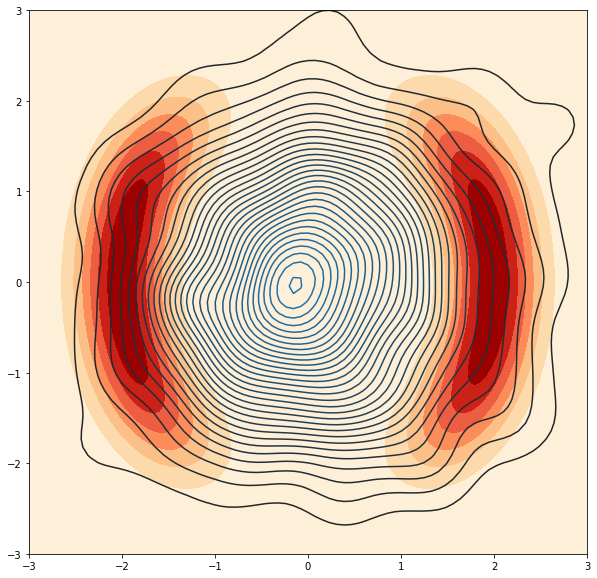

In [8]:
x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(x1, x2)
P = np.exp(DualMoonDistribution().log_prob(np.stack([X1, X2], axis=-1)))

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.contourf(X1, X2, P, cmap='OrRd')
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'][:, 0], svgd.get_params(svgd_state)['auto_x'][:, 1], n_levels=30, ax=ax)


In [9]:
rng_key = jax.random.PRNGKey(142)

num_iterations = 250
svgd_state, loss = svgd.run(rng_key, num_iterations)

SVGD 0.64905: 100%|██████████| 250/250 [01:38<00:00,  2.53it/s]


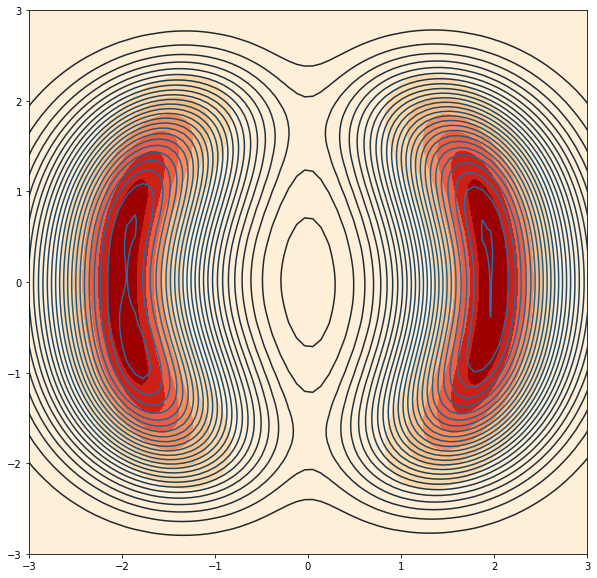

In [10]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.contourf(X1, X2, P, cmap='OrRd', )
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'][:, 0], svgd.get_params(svgd_state)['auto_x'][:, 1], n_levels=30, ax=ax)

In [11]:
def make_iafs(num_iaf, input_dim, hidden_dims):
    flows = []
    for i in range(num_iaf):
        arn = AutoregressiveNN(input_dim, hidden_dims, permutation=np.arange(input_dim),
                               nonlinearity=stax.Elu)
        arnn = numpyro.module(f'arn_{i}', arn, (input_dim,))
        flows.append(InverseAutoregressiveTransform(arnn))
        if i < num_iaf - 1:
            flows.append(PermuteTransform(np.arange(input_dim)[::-1]))
    return flows

In [13]:
def neural_transport_guide(num_iaf=3, hidden_dims=[2,2]):
    flows = make_iafs(num_iaf, 2, hidden_dims)
    particle = numpyro.param('particle', init_value=jnp.array([0,0]))
    numpyro.sample('x', dist.TransformedDistribution(dist.Delta(particle), flows))

In [14]:
rng_key = jax.random.PRNGKey(142)
guide = WrappedGuide(neural_transport_guide,
                     lambda site: site['name'].endswith("$params"))
svgd = SVGD(dual_moon_model, 
            guide,
            Adam(step_size=0.01), ELBO(), RBFKernel(), num_particles=1000,
            classic_guide_params_fn=lambda name: name.startswith("arn"))
svgd_state = svgd.init(rng_key)

AttributeError: module 'numpyro' has no attribute 'rng_key'

In [12]:
num_iterations = 250
svgd_state, loss = svgd.run(rng_key, num_iterations)

SVGD -0.082322: 100%|██████████| 250/250 [03:34<00:00,  1.17it/s]


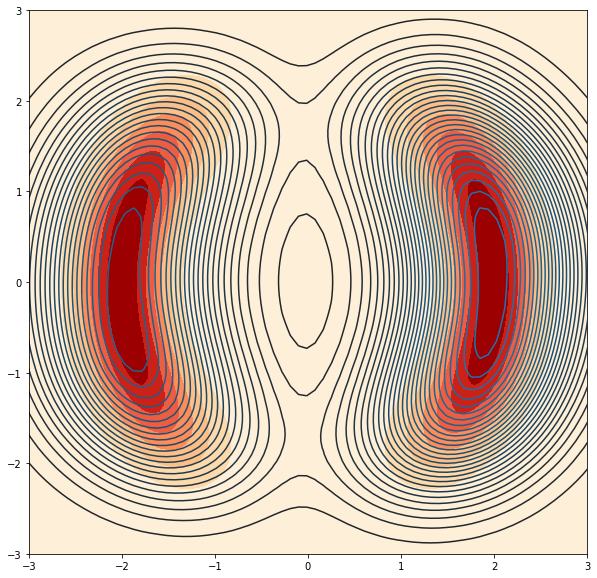

In [13]:
samples = svgd.predict(svgd_state)
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.contourf(X1, X2, P, cmap='OrRd')
sns.kdeplot(samples['x'][:, 0], samples['x'][:, 1], n_levels=30, ax=ax)

## Neal's Funnel

In [14]:
def funnel_pdf(pos):
    prob = dist.Normal(0,3).log_prob(pos[:,:,1]) + dist.Normal(0, np.exp(pos[:,:,1]/2)).log_prob(pos[:,:,0])
    return np.exp(prob)
x, y = np.meshgrid(np.linspace(-20, 20, 500), np.linspace(-9, 9, 100))
probs = funnel_pdf(np.stack([x, y], axis=-1))
probs

DeviceArray([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
             [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
             [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
              0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
             ...,
             [1.0822454e-05, 1.0825530e-05, 1.0828587e-05, ...,
              1.0828587e-05, 1.0825530e-05, 1.0822454e-05],
             [8.3337018e-06, 8.3356808e-06, 8.3376362e-06, ...,
              8.3376362e-06, 8.3356808e-06, 8.3337018e-06],
             [6.3874713e-06, 6.3887383e-06, 6.3899938e-06, ...,
              6.3899938e-06, 6.3887383e-06, 6.3874713e-06]],            dtype=float32)

### Normal SVGD

In [15]:
def funnel(dim=10):
    y = numpyro.sample('y', dist.Normal(0, 3))
    numpyro.sample('x', dist.Normal(np.zeros(dim - 1), np.exp(y / 2)))

In [16]:
dim = 10
rng_key = jax.random.PRNGKey(142)
guide = AutoDelta(funnel, init_strategy=init_with_noise(init_to_value({'x': np.array([0.]*(dim-1)), 'y': np.array([1.])}), noise_scale=3.0))
svgd = SVGD(funnel, guide, Adam(step_size=0.01), ELBO(),
            RBFKernel(mode='vector'), num_particles=100)
svgd_state = svgd.init(rng_key)

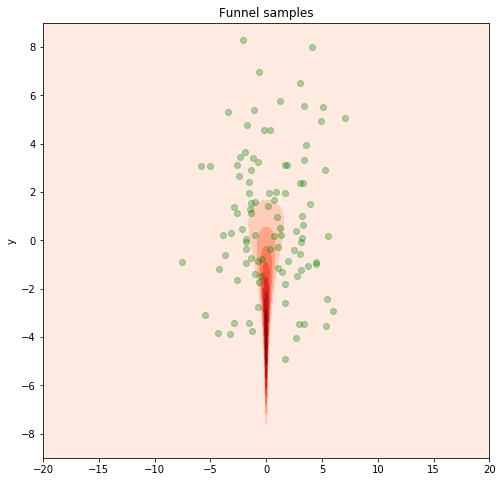

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.contourf(x,y,probs,cmap='Reds',)  # contour of funnel
ax.plot(svgd.get_params(svgd_state)['auto_x'][:, 0], svgd.get_params(svgd_state)['auto_y'], "go", alpha=0.3)
ax.set(xlim=(-20, 20), ylim=(-9, 9), ylabel='y', title='Funnel samples')
plt.show()

In [18]:
svgd_state, loss = svgd.run(rng_key, 10000)

SVGD 3.9897: 100%|██████████| 10000/10000 [02:50<00:00, 58.69it/s]


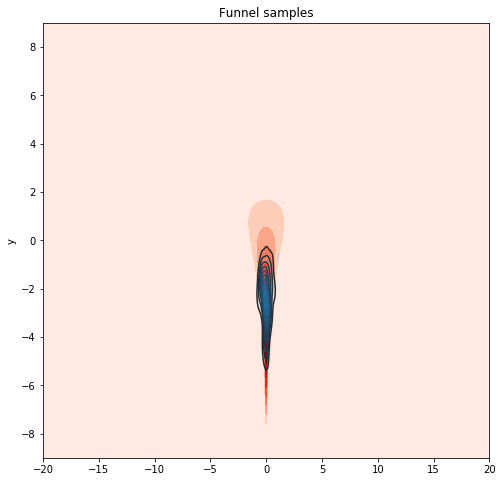

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.contourf(x,y,probs,cmap='Reds',)  # contour of funnel
sns.kdeplot(svgd.get_params(svgd_state)['auto_x'][:, 0], svgd.get_params(svgd_state)['auto_y'], ax=ax)
ax.set(xlim=(-20, 20), ylim=(-9, 9), ylabel='y', title='Funnel samples')
plt.show()

### Neural Transport SVGD

In [29]:
def neural_transport_guide(num_iaf=3, hidden_dims=[dim,dim]):
    flows = make_iafs(num_iaf, dim, hidden_dims)
    particle = numpyro.param('particle', init_value=np.zeros(dim))
    tparticle = dist.transforms.ComposeTransform(flows)(particle)
    numpyro.sample('y', dist.Delta(tparticle[0]))
    numpyro.sample('x', dist.Delta(tparticle[1:]))

In [30]:
dim = 10
rng_key = jax.random.PRNGKey(142)
guide = WrappedGuide(neural_transport_guide, lambda site: site['name'].endswith("$params"),
                     init_strategy=init_with_noise(init_to_value({'particle': np.zeros(dim)}), noise_scale=3.0))
svgd = SVGD(funnel, guide, Adam(step_size=3e-4), ELBO(),
            RBFKernel(), num_particles=100,
            classic_guide_params_fn=lambda name: name.startswith("arn"))
svgd_state = svgd.init(rng_key)

In [31]:
svgd_state, loss = svgd.run(rng_key, 10000)

SVGD -9.4054: 100%|██████████| 10000/10000 [04:28<00:00, 37.30it/s]


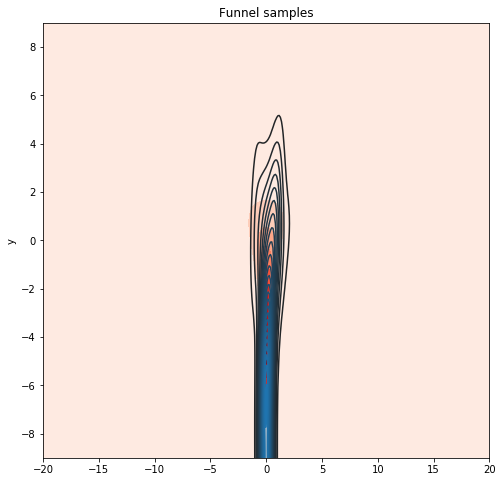

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.contourf(x,y,probs,cmap='Reds',)  # contour of funnel
samples = svgd.predict(svgd_state)
sns.kdeplot(samples['x'][:, 0], samples['y'], n_levels=30, ax=ax)
ax.set(xlim=(-20, 20), ylim=(-9, 9), ylabel='y', title='Funnel samples')
plt.show()